# Biocircuit Design

<hr>

**Learning objectives**
- You can define the classification basis for logic gates. (#1)
- You can write down the boolean logic for logic gates. (#2)
- You can generate a truth table for a biological system. (#4)
- You can distinguish *and* and *or* relationships. (#3)
<hr>

### Exercise: Design a biocircuit for *Pseudomonas putida* carbon metabolism

[*Pseudomonas putida*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4495716/) is an industrial relevant microorganism which naturally produces PHA, a plastic precursor monomer. For a very specific process, we would like to design a circuit which enables us to make optimally use of our carbon resources. The preferred substrate for this specific proces is glucose. Glycerol can also be used, but results a lower product yield. We have a recycled feedstock which constains a mixture of glucose and glycerol. To make optimally use of the available glucose, we want to have a consumption profile where fist all glucose is consumed, before *P. putida* starts to consume glycerol. You can assume that the pathway is activated when the metabolite is present.

<div style="width: 500px; margin: auto;">

![Desired metabolite consumption pattern](desired_metabolite_profile.png)

</div>

Your job is to design a biocircuit which enables this phenotype. Work through the material to get all the tools needed to solve the following exercises.

1. Formulate a truth table for the glycerol pathway. 
2. Define the type of logic gate which you would use for each pathway, and write down the boolean logic.
3. Think about the genetic components and levels needed to accomplish the logic gates, sketch a genetic interaction figure. Try to use as little genetic components as possible
4. Combine the elements to design the experiment for the establishment of the genetic circuit. You have to pick one promoter (either activated by glucose or glycerol) and one regulator (glucose metabolism activator/repressor, or gycerol metabolism activator/repressor)

In [2]:
#Run this cell to set up the computing environment
import numpy as np
import os
import random
 
try:
    import pydna
except ImportError:
    print("pydna not found, installing...")
    %pip install pydna
    import pydna
from pydna.design import primer_design
from pydna.amplify import pcr
from pydna.dseqrecord import Dseqrecord
from pydna.gel import gel
from pydna.ladders import GeneRuler_1kb_plus

from BioCircuitSim_functions import (get_promoter_sequence, get_activator_sequence, get_repressor_sequence, 
                                     get_putida_genome, perform_batch_experiment, perform_pcr)

Target_Dir = os.path.join(os.getcwd(),'Data','BioMotifSim')

print('Done!')

Done!


## Brief introduction to biocircuits
The material presented here will introduce you to some of the foundational concepts, approaches, and examples of biocircuits that will enable us to address the biological challenge of designing an experiment to enable a specific phenotype in *P. putida*. The key premise is that this problem and many similar problems can be addressed by thinking of biological systems in terms of *circuits* -- sets of molecular or cellular components that interact with another in specific ways.

In this notebook we will use the idea of a circuit and the corresponding logic to enable a specific feature. We will show how to effectively analyze a problem and define a solution based on these principles.

<hr>

## Logic of regulation 
In the example of carbon metabolism in *P. putida*, we need to define the specific interaction between the metabolites and the metabolism of these metabolites. Because glucose and glycerol are both present in our envisioned bioprocess, we need to specify how each metabolite needs to *interact* with the expressed systems.

For the sake of illustration, let us assume we are discussing the effect of glucose and glycerol on glucose metabolism. As an example, we take the scenario where both glucose and glycerol are required to activate carbon metabolism. For example, both could be binding partners for the recruitment of polymerase to the promoter of a sugar transporter. We call this **AND logic**. In other words, to get expression of the sugar transporter, we must have `glucose AND glycerol`. Conversely, if either glucose or glycerol may each alone activate carbon metabolism, we have **OR logic**. That is, to get expression of the sugar transporter, we must have `glucose OR glycerol`.

### Formulation of logic in a truth table
Applying this logic to a simple example might be straightforward, but it can quickly become complex when applied to real biological systems. 
Let us start first with the simple example as before with glucose and glycerol, both activating, with AND logic. To help conceptualize how the logic translates into expression of carbon metabolism, we can construct a **truth table** for whether or not carbon metabolism (cmet) is on, given the on/off status of glucose (glc) and glycerol (gly). The truth table is shown below, with a zero entry meaning that the gene is not on and a one entry meaning it is on.


glc | gly | cmet
:---:|:---:|:----------:
0 | 0 | 0
0 | 1 | 0
1 | 0 | 0
1 | 1 | 1

We can also construct a truth table for OR logic with glucose and glycerol both activating.


glc | gly | cmet
:---:|:---:|:----------:
0 | 0 | 0
0 | 1 | 1
1 | 0 | 1
1 | 1 | 1

Before going to the next part of the notebook, think about the truth table for glucose metabolism in the exercise. What is the envisioned relation between presence of glucose and glycerol on the metabolism of glucose? Check your answer with the truth table at the end of this notebook


### Connection to logic gates

When two "input" effectors regulate the expression of a single "output" gene, we are tempted to connect the circuit architectures to [logic gates](https://en.wikipedia.org/wiki/Logic_gate). This is both useful and dangerous.

First, we will discuss the utility. [Boolean algebra](https://en.wikipedia.org/wiki/Boolean_algebra) is a very powerful tool in developing circuits in digital electronics, and may also be a powerful framework for designing biological circuits. Briefly, Boolean algebra deals with only trues and falses, or ones and zeros. It has three fundamental operations, conjuction (∧), disjunction (∨), and negation (¬). They are defined such that 

\begin{align}
&a \land b = \left\{\begin{array}{ll}
1 & \text{if } a=b=1 \\
0 & \text{otherwise},
\end{array}
\right.\\[1em]
&a \lor b = \left\{\begin{array}{ll}
0 & \text{if } a=b=0 \\
1 & \text{otherwise},
\end{array}
\right.\\[1em]
&\lnot a = \left\{\begin{array}{ll}
0 & \text{if } a=1 \\
1 & \text{if } a=0.
\end{array}
\right.
\end{align}

One could think of two activators X and Y regulating expression of a gene Z with AND logic as Z = X ∧ Y. The relation X ∧ Y has a name; it is called an AND gate. The other architectures also represent logic gates. Below is a table of the analogous logic gates and Boolean algebra expressions for the two-effector regulation architectures we have considered.

X | Y | regulatory logic |Boolean algebra
:---:|:---:|:----------:|:---:|
activator | activator | AND | X ∧ Y
activator | activator | OR | X ∨ Y
repressor | repressor | AND | ¬X ∧ ¬Y = ¬(X ∨ Y)
repressor | repressor | OR | ¬X ∨ ¬Y = ¬(X ∧ Y)
activator | repressor | AND |  X ∧ ¬Y
activator | repressor | OR | X ∨ ¬Y


Now, let's consider the danger in using digital logic with these circuits. While thinking digitally for these circuits has its merit, we must always remember that biological circuits are more fuzzy. If you will attend the lecture about logic gates later in the lecture series, you will learn more about the why and how.

<hr>

## Starting the exercises

Now you have gathered enough knowledge to perform the exercises. First, try to answer question 1 til 3, which will give you a theoretical model of the problem we are trying to solve. Afterwards, you can continue with implementing your biocircuit. In the following cells, you find the code required for making exercise 4. You only have to change those parts which are marked with multiple `#`.

### Execution of exercise 4
First we need to decide on the parts which should go in the construct. We will make a construct of a gene encoding for a regulatory molecule. The gene expression can be made conditional, by adding a inducible promoter which drives the expression of this gene. In the following *genetic interaction figure* you see how this works for a promoter inducible by glucose: if glucose is present, RNA polymerase will bind and express the gene behind the promoter, if glucose is absent, the polymerase will not bind and the gene will not be expressed. The gene behind the promoter in the example is a gene which activates the metabolism of glucose into biomass and PHA.  
  

<div style="width: 500px; margin: auto;">

![example promoter+regulator](biocircuits_construct_example.png)

</div>

You can choose out of the following parts to make your constructs:
promoter | induced by 
:---:|:---:
promoter_glc | glucose 
promoter_glyc | glycogen 

and

regulator gene | mode of action | affects metabolism of
:---:|:---:|:---:
glucose_activator | activation | glucose 
glucose_repressor | repression | glucose
glycerol_activator | activation | glycerol
glycerol_repressor | repression | glycerol

In [1]:
#####################################################
# FILL IN YOUR STUDENT ID
student_number = None
# END OF CODE
#####################################################

try:
    random.seed(student_number)
except:
    raise KeyError('Please provide your student number in the previous cell, otherwise the code will not run')
    
#We obtain the sequences of the promoters and regulators from an in-house library
promoter_glc = get_promoter_sequence(activator = 'glucose')
promoter_glyc = get_promoter_sequence(activator = 'glycerol')

glucose_activator = get_activator_sequence(metabolism = 'glucose')
glucose_repressor = get_repressor_sequence(metabolism = 'glucose')
glycerol_activator = get_activator_sequence(metabolism = 'glycerol')
glycerol_repressor = get_repressor_sequence(metabolism = 'glycerol')

KeyError: 'Please provide your student number in the previous cell, otherwise the code will not run'

In [4]:
#######################################################
# FILL YOUR DECISION IN HERE
promoter = None
regulator = None
# END OF CODE
#######################################################

print(f'The promoter of length {len(promoter)} nt is: {promoter}')
print(f'The repressor of length {len(regulator)} is: {regulator}')

The promoter of length 56 nt is: TTCTCGATACAGTTCACGCCCTTGCGAGTAGCTTGTAATTGCTCTTCTGGGGGTCA
The repressor of length 174 is: TCGGGCTATAGGCGCTCAGGCCGGCCCGGACGGATCGAGCTGGAGGCCTGACCTCCGTATGGTTCCCGACACTTTAGCGCATCTGCGACAGAGAGTGGTTACACGTTTTGCAGTGCGGTAAAATCCTTTCATTAGCCCTCCCGGGAAGCAGGCACGGGGTTTCTATATAGTAGA


##### Do the cloning
Now you have designed the circuit, we only have to insert it into *P. putida*. Assuming your colleagues have implemented this already, all you need to do is run a PCR to validate the results

In [5]:
# create the insert sequence and see how the DNA looks like
insert = Dseqrecord(promoter+regulator)
insert.add_feature()
insert.figure()

/home/samiralvdb/Software/anaconda3/envs/BioLabSim_py39/lib/python3.9/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(


Dseqrecord(-230)
TTCTCGATACAGTTCACGCCCTTGCGAGTAGCTTGTAATTGCTCTTCTGGGGGTCATCGGGCTATAGGCGCTCAGGCCGGCCCGGACGGATCGAGCTGGAGGCCTGACCTCCGTATGGTTCCCGACACTTTAGCGCATCTGCGACAGAGAGTGGTTACACGTTTTGCAGTGCGGTAAAATCCTTTCATTAGCCCTCCCGGGAAGCAGGCACGGGGTTTCTATATAGTAGA
AAGAGCTATGTCAAGTGCGGGAACGCTCATCGAACATTAACGAGAAGACCCCCAGTAGCCCGATATCCGCGAGTCCGGCCGGGCCTGCCTAGCTCGACCTCCGGACTGGAGGCATACCAAGGGCTGTGAAATCGCGTAGACGCTGTCTCTCACCAATGTGCAAAACGTCACGCCATTTTAGGAAAGTAATCGGGAGGGCCCTTCGTCCGTGCCCCAAAGATATATCATCT

#### Do the PCR

In [18]:
#design the primers for pcr amplification
primers = primer_design(insert)
#get the modified
putida_genome = get_putida_genome(promoter, regulator)

# Do the PCR
pcr_product = perform_pcr(primers.forward_primer, primers.reverse_primer, putida_genome)

check if your PCR worked out by visualizing the resulting product and running a gel. If it didn't work, you can rerun the PCR.

In [19]:
# If you want to see your pcr product, uncomment the next line of code
#pcr_product[0].figure()

Dseqrecord(-57)
TTCTCGATACAGTTCACGTCTACTATATAGAAACCCCGTTTCTCGATACAGTTCACG
AAGAGCTATGTCAAGTGCAGATGATATATCTTTGGGGCAAAGAGCTATGTCAAGTGC

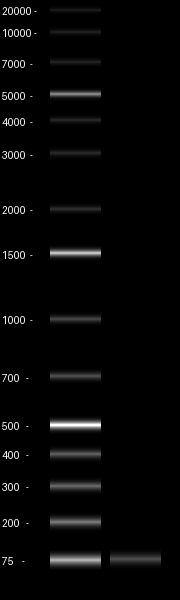

In [24]:
# Create a gel to see if the PCR and insertion worked
im = gel(
    [GeneRuler_1kb_plus,
     [pcr_product], #The pcr product of the genome: is your construct in there?
    ])

im

#### Check the resulting metabolite consumption profiles
Now we are sure that the insert is there, we will run some experiments to check if we get the required phenotype. In this case we are interested in the metabolite consumption profile of glucose and glycerol.

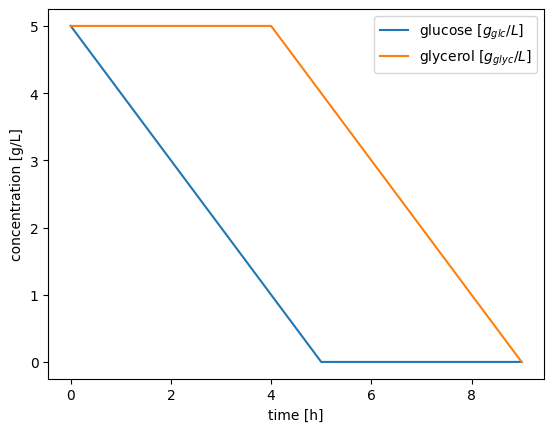

In [9]:
perform_batch_experiment(putida_genome, pcr_product)

## Additional material
Did you enjoy working with the concepts introduced in this seminar? If yes, we recommend the following resources:
- The Jupyter-book by [Elowitz and Bois](https://biocircuits.github.io/index.html) gives detailed treatment and further examples for different models of genetic circuits. 
- With the python package [pydna](https://github.com/BjornFJohansson/pydna), you cannot only do 'in silico' experiments like in this notebook, but you can also build your lab notebook in Python. They even provide a [web interface](http://pydna.pythonanywhere.com/), which allows you to design primers and do PCR.
- Marc Facciotti from the university of California has made a good [webpage](https://bio.libretexts.org/Courses/University_of_California_Davis/BIS_2A%3A_Introductory_Biology_(Britt)/02%3A_Face-2-Face/2.10%3A_Regulation_of_Gene_Expression) about the principles and patterns in the regulation of gene expression.

<hr>

## References

- Bintu, L., et al., Transcriptional regulation by the numbers: models, _Curr. Op. Genet. Dev._, 15, 116–124, 2005.([link](https://doi.org/10.1016/j.gde.2005.02.007))
- Milo, R., et al., Network motifs: Simple building blocks of complex networks, _Science_, 298, 824–827, 2002. ([link](https://doi.org/10.1126/science.298.5594.824))

<hr>

## Answer: truth table of the metabolism of glucose

glc | gly | cmet
:---:|:---:|:----------:
0 | 0 | 0
1 | 0 | 0
0 | 1 | 0
1 | 1 | 1